   session_id       date       season day_of_week time_of_day  \
0      771155 2023-05-01  Mothers Day      Monday       Night   
1      999159 2023-05-01  Mothers Day      Monday   Afternoon   
2      203355 2023-05-01  Mothers Day      Monday     Morning   
3      256730 2023-05-01  Mothers Day      Monday   Afternoon   
4      431236 2023-05-01  Mothers Day      Monday   Afternoon   

   session_duration  page_views  device  bounce  transactions  
0          6.295377           9  Mobile   False             1  
1          5.785160           2  Mobile   False             2  
2          5.483925           1  Mobile   False             0  
3          4.497912           4  Mobile   False             2  
4          3.799492           7  Mobile   False             2  


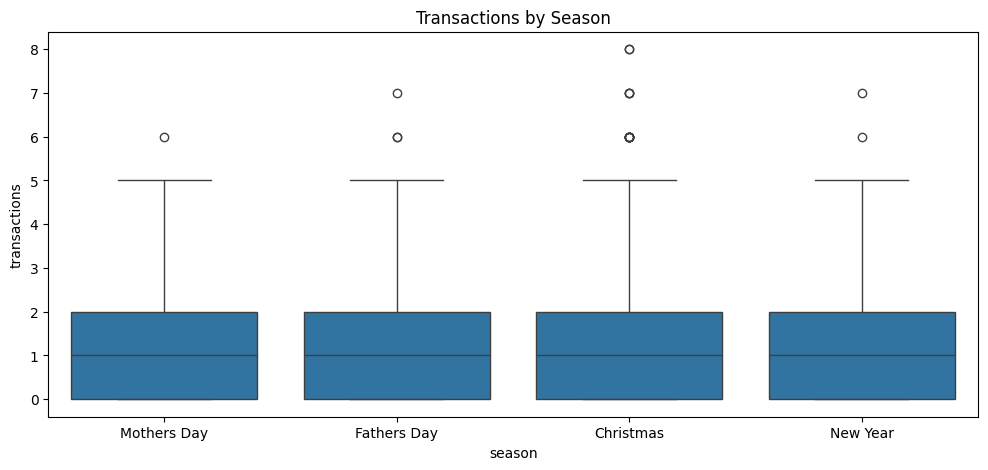

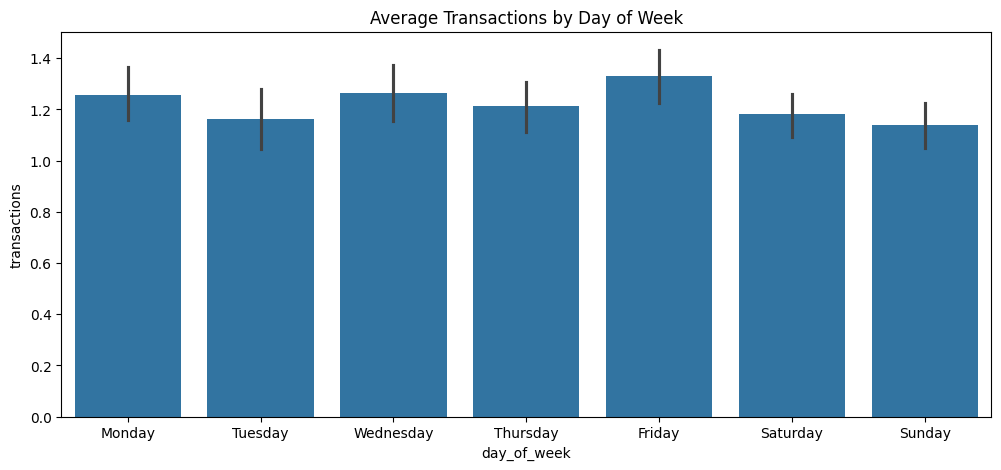

Linear Regression RMSE: 1.225
Linear Regression R2: 0.177
Random Forest RMSE: 1.368
Random Forest R2: 0.081


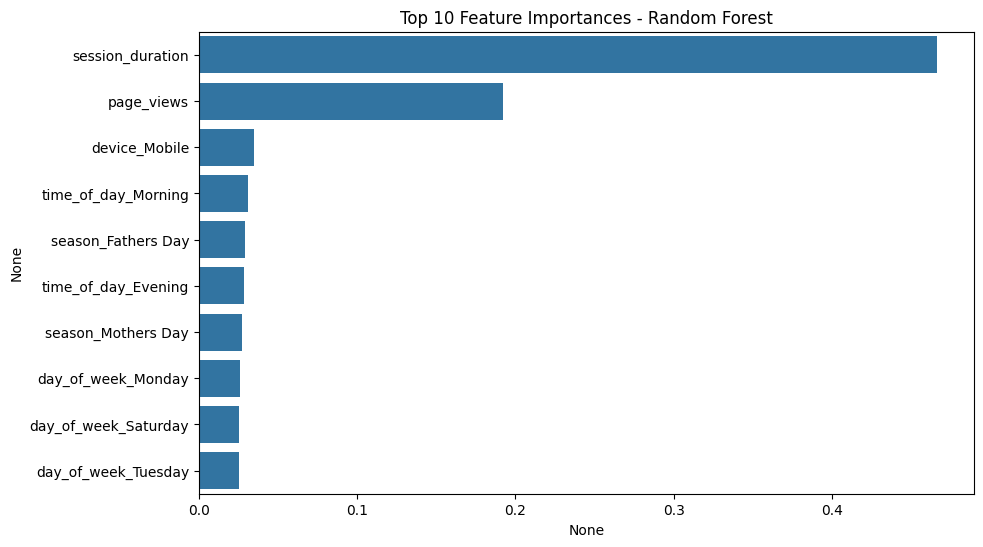

In [3]:
# Seasonal Traffic Forecasting for BackPocket Gifting Site

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor



np.random.seed(42)

# Define date ranges for seasons
christmas = pd.date_range(start='2023-12-15', end='2023-12-31')
mothers_day = pd.date_range(start='2023-05-01', end='2023-05-14')
fathers_day = pd.date_range(start='2023-06-01', end='2023-06-18')
new_year = pd.date_range(start='2023-12-26', end='2024-01-07')

dates = christmas.union(mothers_day).union(fathers_day).union(new_year)

# Create data rows
data = []

for date in dates:
    for _ in range(np.random.randint(50, 100)):  # random sessions per day
        session_id = np.random.randint(100000, 999999)
        season = ''
        if date in christmas:
            season = 'Christmas'
        elif date in mothers_day:
            season = 'Mothers Day'
        elif date in fathers_day:
            season = 'Fathers Day'
        elif date in new_year:
            season = 'New Year'

        day_of_week = date.day_name()
        time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], p=[0.3,0.4,0.2,0.1])
        session_duration = max(0.5, np.random.normal(5, 2))  # minutes
        page_views = max(1, int(np.random.normal(5, 3)))
        device = np.random.choice(['Mobile', 'Desktop'], p=[0.7, 0.3])
        bounce = session_duration < 1

        # Simple transaction logic: longer sessions and more page views increase chance of transactions
        base_trans = 0
        if bounce:
            transactions = 0
        else:
            # Transactions depend on session duration, page views, and season
            season_factor = {'Christmas': 2, 'Mothers Day': 1.5, 'Fathers Day': 1.2, 'New Year': 1.8}.get(season, 1)
            transactions = np.random.poisson(lam=0.1*session_duration + 0.1*page_views*season_factor)

        data.append([
            session_id, date, season, day_of_week, time_of_day, session_duration,
            page_views, device, bounce, transactions
        ])

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    'session_id', 'date', 'season', 'day_of_week', 'time_of_day',
    'session_duration', 'page_views', 'device', 'bounce', 'transactions'
])

# Preview data
print(df.head())

# 2. Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,5))
sns.boxplot(x='season', y='transactions', data=df)
plt.title('Transactions by Season')
plt.show()

# Average transactions by day of week
plt.figure(figsize=(12,5))
sns.barplot(x='day_of_week', y='transactions', data=df, estimator=np.mean, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Transactions by Day of Week')
plt.show()

# 3. Prepare data for modeling

# Encode categorical variables
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['season', 'day_of_week', 'time_of_day', 'device'], drop_first=True)

# Features and target
X = df_model.drop(columns=['session_id', 'date', 'transactions', 'bounce'])
y = df_model['transactions']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train models

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear Regression RMSE: {mean_squared_error(y_test, y_pred_lr):.3f}")
print(f"Linear Regression R2: {r2_score(y_test, y_pred_lr):.3f}")

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf):.3f}")
print(f"Random Forest R2: {r2_score(y_test, y_pred_rf):.3f}")

# 5. Feature importance from Random Forest
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()